# Постановка задач
существует мировая сеть приемников ГНСС. Данные этой сети можно использовать для исследования влияния движения МКС на атмосферу (ионосферу)

## до начала работы необходимо поставить пакет coordinates (conda install coordinates / pip install coordinates)

In [1]:
import numpy as np
import pandas as pd              # работа с таблицами
import matplotlib.pyplot as plt  # графики
#from geopy import distance
from math import radians, cos, sin, asin, sqrt
from numba import jit, njit
import pickle

In [2]:
# данные о пролетах МКС за 2014 год:

#file = 'C:/Users/anisi/Downloads/diplom/ISS_2014-01.h5'
#data = pd.read_hdf(file)  
#data['time'] = data.index
#data.index = range(data.shape[0])
#data.columns = 'lat lon alt time'.split()
#data['time lat lon alt'.split()]

In [3]:
data = pd.read_csv('temp.csv', names='time lat lon alt'.split(),skiprows=1)

In [4]:
lat_rad = []
lon_rad = []
data['lat_rad'] = np.deg2rad(data.lat)
data['lon_rad'] = np.deg2rad(data.lon)
data


,time,lat,lon,alt,lat_rad,lon_rad
0,2014-01-01 00:00:00,-50.333535,-0.742741,433.111337,-0.878486,-0.012963
1,2014-01-01 00:00:01,-50.349450,-0.649372,433.114031,-0.878764,-0.011334
2,2014-01-01 00:00:02,-50.365284,-0.555937,433.116692,-0.879040,-0.009703
3,2014-01-01 00:00:03,-50.381035,-0.462438,433.119321,-0.879315,-0.008071
4,2014-01-01 00:00:04,-50.396704,-0.368874,433.121917,-0.879588,-0.006438
...,...,...,...,...,...,...
86395,2014-01-01 23:59:55,51.121425,179.125495,422.904394,0.892237,3.126330
86396,2014-01-01 23:59:56,51.132453,179.222486,422.910568,0.892430,3.128022
86397,2014-01-01 23:59:57,51.143393,179.319525,422.916721,0.892621,3.129716
86398,2014-01-01 23:59:58,51.154246,179.416612,422.922854,0.892810,3.131411


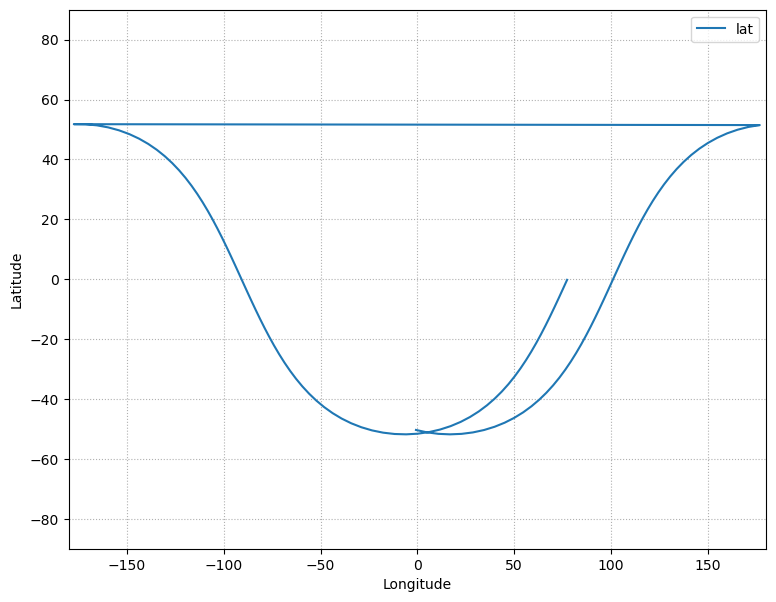

In [5]:
# Подготовим рисунок:
fig, ax = plt.subplots(figsize=(9,7))

data.columns = 'time', 'lat', 'lon', 'alt', 'lat_rad', 'lon_rad'
minute_resolution = data[::60]
minute_resolution[:120].plot(x='lon', y='lat', ax=ax)

plt.grid(ls=":")
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [6]:
minute_resolution[:120].index

RangeIndex(start=0, stop=7200, step=60)

## задача 1: 
нам нужно определить даты и интервалы времени, когда МКС находилась над областями плотного расположения приемников.
Мы возьмем три региона: Калифорния, Япония и Европа

In [7]:
path = './regions'
stations = []  # список, содержащий таблицы по каждому из трех регионов
for region in 'cal', 'jap', 'eur':
    stations.append(pd.read_csv(f'{path}/{region}.lst', names='site lat lon'.split()))
    

In [8]:
sites = stations[0]# это первые 10 станций в Калифорнии
stations

[      site      lat       lon
 0     7odm  34.1167 -117.0932
 1     acsb  33.2745 -117.4449
 2     agmt  34.5947 -116.4294
 3     alpp  34.8248 -118.6948
 4     alth  36.8899 -120.6698
 ...    ...      ...       ...
 1243  kdcb  36.3835 -119.0906
 1244  plmo  39.4333 -121.6046
 1245  port  36.0413 -119.0169
 1246  sod2  37.1664 -121.9255
 1247  spig  31.0461 -115.4660
 
 [1248 rows x 3 columns],
      site      lat       lon
 0    0194  39.1859  139.5477
 1    019b  39.1859  139.5477
 2    aira  31.8244  130.5996
 3    ccj2  27.0678  142.1950
 4    chan  43.7910  125.4442
 ..    ...      ...       ...
 187  khab  48.4954  135.0499
 188  uskh  47.0350  142.7165
 189  plvs  30.8431  121.5215
 190  prt2  43.1226  133.1261
 191  brgv  42.7711  133.0608
 
 [192 rows x 3 columns],
      site      lat      lon
 0    acor  43.3647  -8.3989
 1    ajac  41.9278   8.7626
 2    alac  38.3392  -0.4812
 3    alme  36.8528  -2.4594
 4    ambl  49.8597   0.9943
 ..    ...      ...      ...
 942  rets

In [9]:
site = sites.iloc[12]
site

site       avry
lat     34.4686
lon    -117.154
Name: 12, dtype: object

Написать функцию: для заданной станции она возвращает моменты времени, когда МКС проходила над станцией (или в заданном радиусе от нее)

In [18]:
def when_iss_passed(station, iss_track, r = 0):
    radius = r / (2 * 6371) 
    s_lat = np.deg2rad(station.lat)
    s_lon = np.deg2rad(station.lon)
    gr_lat = radius/ 111.11 #градусы отбора
    gr_lon = gr_lat / cos(s_lat)
    data2 = data[['time', 'lat', 'lon', 'lat_rad', 'lon_rad']].copy()
    data2['station_name'] = station.site
    data2['dlat'] = data2.lat_rad-s_lat
    data2['dlon'] = data2.lon_rad-s_lon
    data2 = data2[(data2['dlat'] < gr_lat) & (data2['dlon'] < gr_lon)]
    data2['sin_dlat2'] = np.sin(data2.dlat/2)**2
    data2['sin_dlon2'] = np.sin(data2.dlon/2)**2
    data2['cos_s_lat'] = np.cos(s_lat)
    data2['cos_lat'] = np.cos(data2.lat_rad)
    data2['arcsin'] = np.arcsin((np.sqrt(data2.sin_dlat2 + data2.cos_lat * data2.cos_s_lat * data2.sin_dlon2)))
    data2 = data2[data2['arcsin'] < radius]
    data2 = data2[['time', 'lat', 'lon']]
    return data2

In [19]:
test = dict()
for i in sites.index[:]:
    item = sites.iloc[i]
    d = when_iss_passed(item, data, 200)
    test[item.site] = d
#на годовой файл ~16 минут, на месяц ~2 минуты 

In [20]:
pickle.dump(test, open('one_day.pkl', 'wb'))

In [21]:
test2 = pickle.load(open('one_day.pkl', 'rb'))
test2

{'7odm':                      time        lat         lon
 3673  2014-01-01 01:01:13  33.277664 -118.981674
 3674  2014-01-01 01:01:14  33.234136 -118.928735
 3675  2014-01-01 01:01:15  33.190581 -118.875854
 3676  2014-01-01 01:01:16  33.147000 -118.823028
 3677  2014-01-01 01:01:17  33.103392 -118.770259
 3678  2014-01-01 01:01:18  33.059758 -118.717546
 3679  2014-01-01 01:01:19  33.016098 -118.664889
 3680  2014-01-01 01:01:20  32.972412 -118.612288
 3681  2014-01-01 01:01:21  32.928700 -118.559742
 3682  2014-01-01 01:01:22  32.884962 -118.507253
 3683  2014-01-01 01:01:23  32.841198 -118.454818
 3684  2014-01-01 01:01:24  32.797408 -118.402440
 3685  2014-01-01 01:01:25  32.753593 -118.350117
 3686  2014-01-01 01:01:26  32.709751 -118.297848
 3687  2014-01-01 01:01:27  32.665884 -118.245636
 3688  2014-01-01 01:01:28  32.621992 -118.193478
 3689  2014-01-01 01:01:29  32.578074 -118.141375
 3690  2014-01-01 01:01:30  32.534130 -118.089326,
 'acsb':                      time       

Функция: на вход станция (имя, координаты), полный массив трека МКС, выход: словарь: имя станции, отобранные метки времени (отсчеты)

Обработать для всех станций, результат сохранить в pickle

## задача 2: 
Для заданного момента времени определить положение спутников GPS, GLONASS, таких, что лучи от них до заданной станции траекторию МКС

In [13]:
%pip install gnss_tec
%pip install git+https://github.com/gnss-lab/coordinates.git

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/gnss-lab/coordinates.git to c:\users\anisi\appdata\local\temp\pip-req-build-pntcypm2
  Resolved https://github.com/gnss-lab/coordinates.git to commit 3f61d5e7988c6d3030acec25a0823f60840c212b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/gnss-lab/coordinates.git 'C:\Users\anisi\AppData\Local\Temp\pip-req-build-pntcypm2'


In [14]:
import gnss_tec
import datetime as dt
from coordinates import satellite_xyz
from sat_geometry_lite import xyz_to_el_az, sub_ionospheric

In [15]:
import json
# Читаем список станций
with open('base.json','rb') as file:
    sites = json.load(file) #10132 позиций

In [16]:
sat_num = 1
nav_file = 'C:/Users/anisi/Downloads/diplom/nav/brdc0010.14n'
gnss_type = 'G'
#g=gps, r=glonass


In [17]:
site = sites[0]
#site_xyz = [-4073662.27, 4712064.75, -1367874.49 ]
timestamp = dt.datetime(2014, 1, 1)
site_xyz = site['xyz']
sat_xyz = satellite_xyz(nav_file, gnss_type, sat_num, timestamp)
sat_xyz
site

{'code': '00na',
 'ftps': ['ftp.sonel.org', 'ftp.ga.gov.au'],
 'height': 5701.92,
 'location': {'lat': -12.4667792, 'lon': 130.8439872},
 'xyz': [-4073662.27, 4712064.75, -1367874.49]}

In [37]:
base_f = list()
site_code = site['code']
for key in test2:
    a = key
    for i in range(1, 10133):
        site = sites[i]
        if site['code'] == a:
            base_f.append(site)
h = 455
site = base_f[20]
code = site['code']
site_test2 = test2.get(code)
timestamp = dt.datetime(2014, 1, 1)
for i in range(1, 33):
    sat_num = i
    site_xyz = site['xyz']
    sat_xyz = satellite_xyz(nav_file, gnss_type, sat_num, timestamp)
    el, az = xyz_to_el_az(site_xyz, sat_xyz)
    h = 455
    if el >= 30:
        ionospheric = sub_ionospheric(site['location']['lat'], site['location']['lon'], h, az, el)
        print(sat_num, ionospheric)
        site_test2['dlat'] = site_test2.lat-ionospheric[0]
        site_test2['dlon'] = site_test2.lon-ionospheric[1]
        site_test2 = site_test2[(site_test2['dlat'] < 40) & (site_test2['dlon'] < 40)]
        print(site_test2)

1 (-1.1527238332259626, -111.60943466022661)
                      time        lat         lon       dlat       dlon
14896  2014-01-01 04:08:16  29.600112 -161.974719  30.752836 -50.365284
15030  2014-01-01 04:10:30  23.335503 -155.835141  24.488227 -44.225706
15031  2014-01-01 04:10:31  23.287627 -155.791902  24.440351 -44.182467
21227  2014-01-01 05:53:47  -8.124051 -155.791713  -6.971327 -44.182278
21469  2014-01-01 05:57:49 -20.174622 -146.462067 -19.021898 -34.852632
26922  2014-01-01 07:28:42 -14.396708 -174.709320 -13.243984 -63.099885
44809  2014-01-01 12:26:49 -51.602510 -165.239312 -50.449786 -53.629877
44810  2014-01-01 12:26:50 -51.596412 -165.140517 -50.443688 -53.531082
11 (0.8009766664563869, -110.95867049571251)
                      time        lat         lon       dlat       dlon
14896  2014-01-01 04:08:16  29.600112 -161.974719  28.799135 -51.016049
15030  2014-01-01 04:10:30  23.335503 -155.835141  22.534526 -44.876471
15031  2014-01-01 04:10:31  23.287627 -155.791

In [20]:
# углы положения спутника на небе восхождение (elevation) и азимут (azimuth)
el, az = xyz_to_el_az(site_xyz, sat_xyz)
el, az

(-1.5952022999722542, 39.483945684963324)

In [120]:
# определение координат точки пересечения луча со слоем на высоте h
h = 455
sub_ionospheric(-12.4667792, 130.8439872, h, az, el)

(1.1781076879735117, 124.60307603810463)

In [20]:
# функция возвращает нам моменты, когда лучи от станции до спутников ГНСС пересекали траекторию МКС
# опция radius дает допустимое расхождение между положением станции и ионосферной точкой (точкой пересечения) луча
def get_crossections(day, site, radius=0):
    
    pass

In [21]:
sites[0]

{'code': '00na',
 'ftps': ['ftp.sonel.org', 'ftp.ga.gov.au'],
 'height': 5701.92,
 'location': {'lat': -12.4667792, 'lon': 130.8439872},
 'xyz': [-4073662.27, 4712064.75, -1367874.49]}

In [25]:
temp_date = dt.datetime(2014,4,22)

In [26]:
temp_date.strftime('%j')

'112'

In [27]:
filename = 'brdc1120.14g'

In [28]:
dt.datetime.strptime(filename, 'brdc%j0.%yg')

datetime.datetime(2014, 4, 22, 0, 0)

In [43]:
test2['cae1']

,time
15932,2014-01-01 04:25:32
